XGBoost MAE: 21.296406923141852
XGBoost MSE: 3583.551020987891
XGBoost RMSE: 59.86276823692579


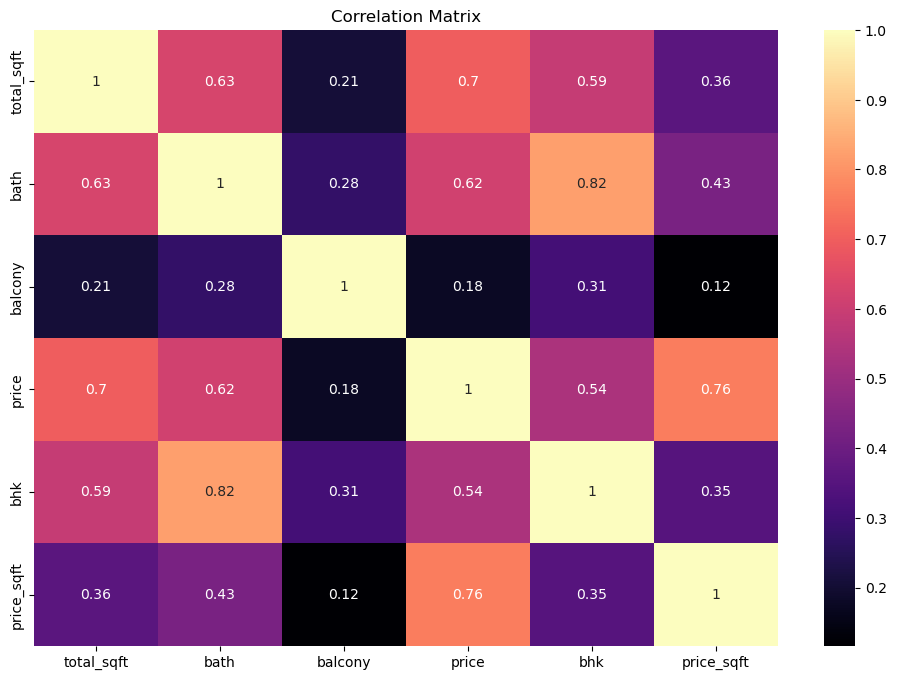

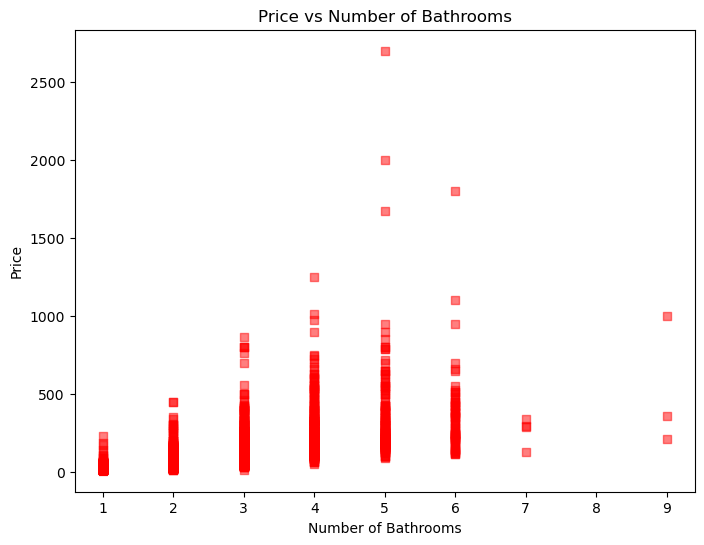

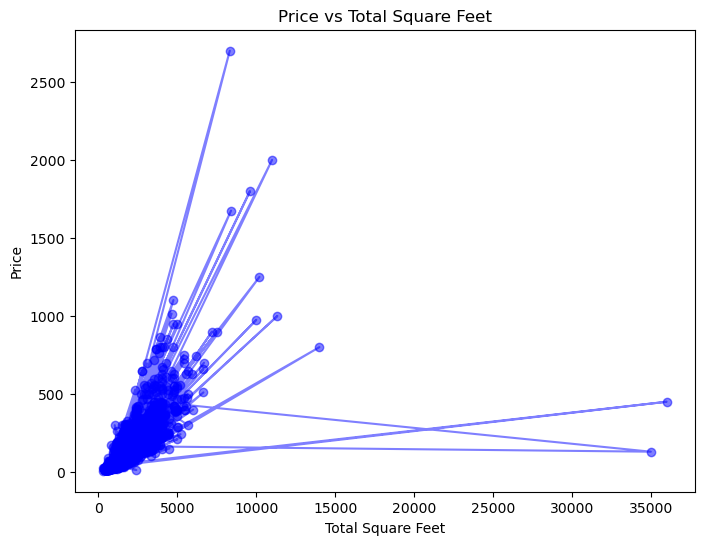

<Figure size 800x600 with 0 Axes>

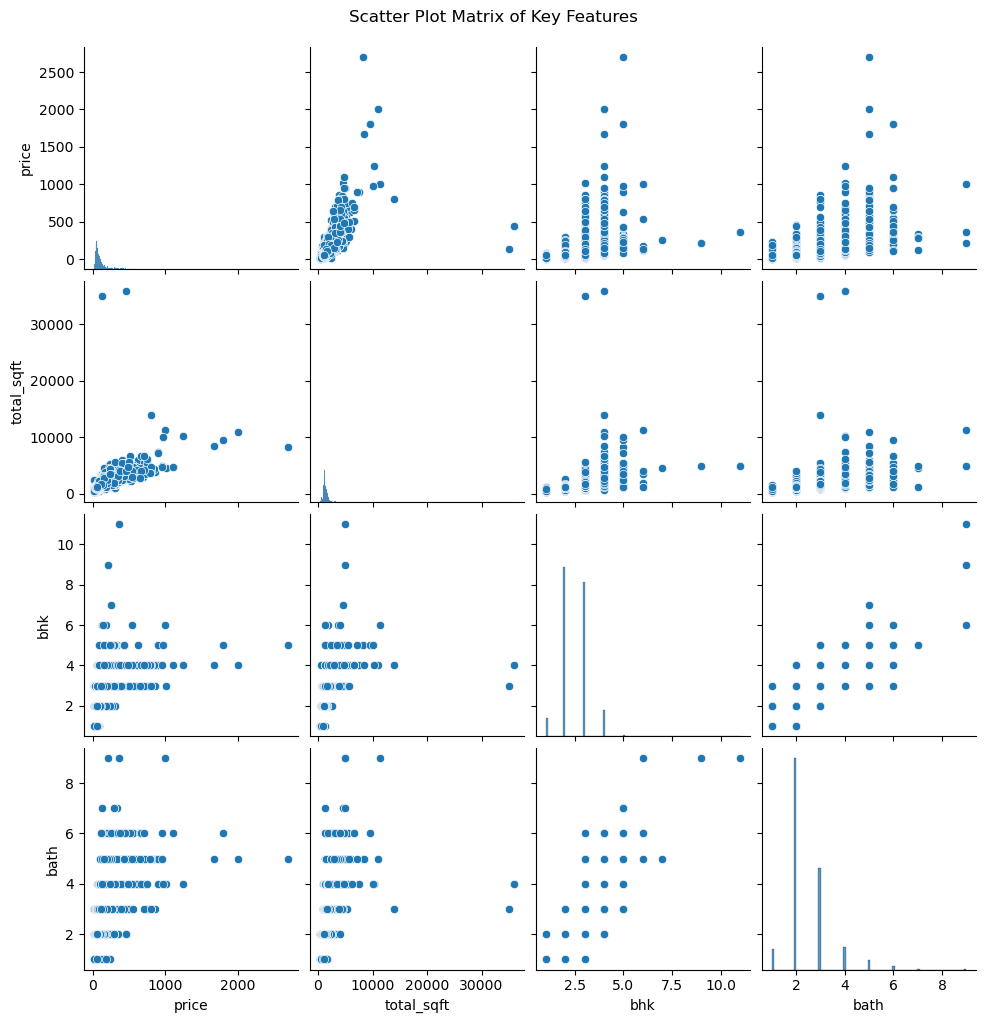

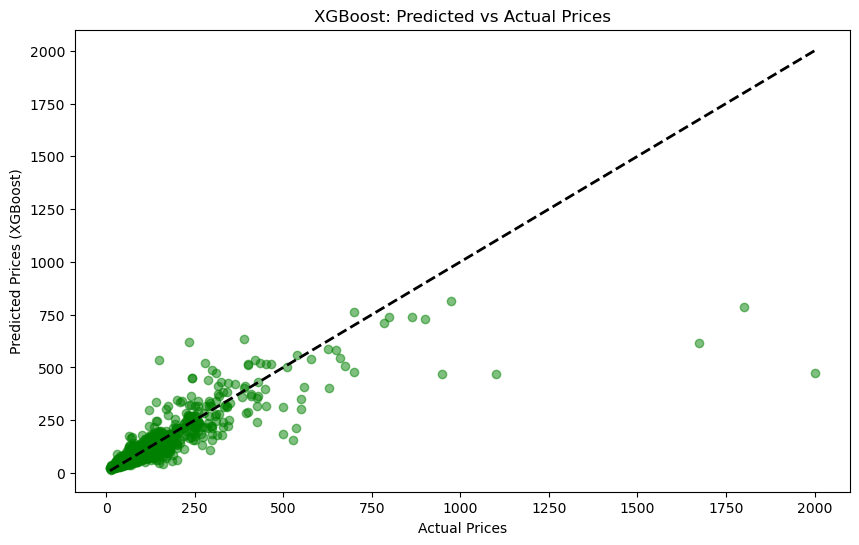

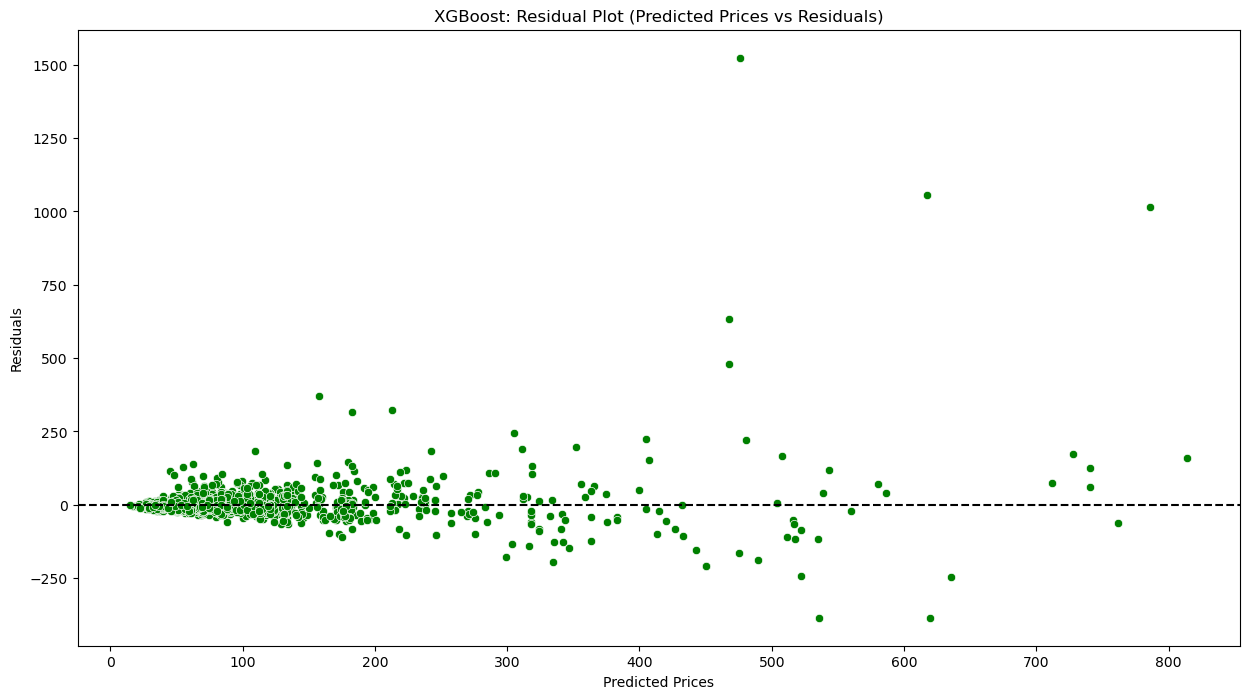

Predicted price for Yelahanka using XGBoost: 220.10242


In [10]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.svm import SVR

# Load the dataset
data = pd.read_csv("House_Data.csv")
data = data.dropna()

# Preprocessing the data
data['bhk'] = data['size'].apply(lambda x: int(x.split(' ')[0]))

def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

data['total_sqft'] = data['total_sqft'].apply(convert_sqft_to_num)
data = data[data['total_sqft'].notnull()]

# Handle outliers
data['price_sqft'] = data['price']*100000 / data['total_sqft']
upper_limit = data['price_sqft'].mean() + 3*data['price_sqft'].std()
lower_limit = data['price_sqft'].mean() - 3*data['price_sqft'].std()
data = data[(data['price_sqft'] < upper_limit) & (data['price_sqft'] > lower_limit)]

# One hot encoding for categorical variables
data = pd.get_dummies(data, columns=['location', 'area_type'], drop_first=True)

# Define dependent and independent variables
X = data.drop(['price', 'price_sqft', 'size', 'availability', 'society'], axis=1)
y = data['price']

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the data for SVM

# Preprocessing steps as before

# Apply XGBoost Regressor
xgb_model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=7, random_state=42)
xgb_model.fit(x_train, y_train)

# Predict on test data
y_pred_xgb = xgb_model.predict(x_test)

# Calculate evaluation metrics
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

# Print metrics
print(f"XGBoost MAE: {mae_xgb}")
print(f"XGBoost MSE: {mse_xgb}")
print(f"XGBoost RMSE: {rmse_xgb}")
# Correlation heatmap
plt.figure(figsize=(12, 8))
numeric_data = data.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='magma')
plt.title('Correlation Matrix')
plt.show()

# Scatter plot between price and bath
plt.figure(figsize=(8, 6))
plt.scatter(data['bath'], data['price'], c='r', marker='s', alpha=0.5)
plt.title('Price vs Number of Bathrooms')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Price')
plt.show()

# Scatter plot between price and total_sqft
plt.figure(figsize=(8, 6))
plt.plot(data['total_sqft'], data['price'], c='b', marker='o', alpha=0.5)
plt.title('Price vs Total Square Feet')
plt.xlabel('Total Square Feet')
plt.ylabel('Price')
plt.show()

# Pairplot for scatter plots between all numeric columns
plt.figure(figsize=(8, 6))
sns.pairplot(numeric_data[['price', 'total_sqft', 'bhk', 'bath']])
plt.suptitle('Scatter Plot Matrix of Key Features', y=1.02)
plt.show()

# Visualizing Predicted vs Actual Prices for XGBoost
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, c='green', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices (XGBoost)')
plt.title('XGBoost: Predicted vs Actual Prices')
plt.show()

# Residual plot (Predicted prices vs Residuals) for XGBoost
residuals_xgb = y_test - y_pred_xgb
plt.figure(figsize=(15, 8))
sns.scatterplot(x=y_pred_xgb, y=residuals_xgb, color='g')
plt.axhline(0, linestyle='--', color='black')
plt.title('XGBoost: Residual Plot (Predicted Prices vs Residuals)')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.show()


# Predict function for XGBoost
def predict_xgb(location, area_type, size, bath, balcony, total_sqft):
    input_data = np.zeros(X.shape[1])
    input_data[0] = total_sqft
    input_data[1] = bath
    input_data[2] = balcony
    input_data[3] = size
    if 'location_' + location in X.columns:
        loc_index = X.columns.get_loc('location_' + location)
        input_data[loc_index] = 1
    if 'area_type_' + area_type in X.columns:
        area_index = X.columns.get_loc('area_type_' + area_type)
        input_data[area_index] = 1
    predicted_price = xgb_model.predict([input_data])
    return predicted_price[0]

print("Predicted price for Yelahanka using XGBoost:", predict_xgb('Yelahanka', 'Super built-up  Area', 3, 3, 2, 3000))
